This tutorial walks you through the process of setting up a dataset for classification, and train a network on it while visualizing the results online. First we need to import the necessary components from PyBrain.

In [1]:
from pybrain.datasets            import ClassificationDataSet
from pybrain.utilities           import percentError
from pybrain.tools.shortcuts     import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.structure.modules   import SoftmaxLayer

Furthermore, pylab is needed for the graphical output.

In [2]:
%matplotlib inline
from pylab import ion, ioff, figure, draw, contourf, clf, show, hold, plot
from scipy import diag, arange, meshgrid, where
from numpy.random import multivariate_normal

To have a nice dataset for visualization, we produce a set of points in 2D belonging to three different classes. 

In [3]:
means = [(-1,0),(2,4),(3,1)]
cov = [diag([1,1]), diag([0.5,1.2]), diag([1.5,0.7])]
alldata = ClassificationDataSet(2, 1, nb_classes=3)
for n in xrange(400):
    for c in range(3):
        inpt = multivariate_normal(means[c],cov[c])
        alldata.addSample(inpt, [c])

Let's show the data in a 2D plot. You will see the colored samples for each class, in three distinct, yet slightly overlapping clusters.

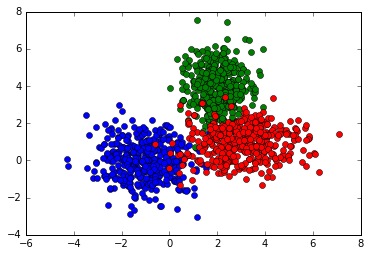

In [4]:
figure(1)
for c in [0,1,2]:
        here, _ = where(alldata['target']==c)
        plot(alldata['input'][here,0],alldata['input'][here,1],'o')

The aim of this tutorial is to train a neural network for classifying any input into its correct class. The dataset is first split into 75% training and 25% test data sets.

In [5]:
trndata, tstdata = alldata.splitWithProportion( 0.75 )

For neural network classification, it is highly advisable to encode classes with one output neuron per class. Note that this operation duplicates the original targets and stores them in an (integer) field named ‘class’.

In [6]:
trndata._convertToOneOfMany( )
tstdata._convertToOneOfMany( )

Test our dataset by printing a little information about it.

In [7]:
print "Number of training patterns: ", len(trndata)
print "Input and output dimensions: ", trndata.indim, trndata.outdim
print "First sample (input, target, class):"
print trndata['input'][0], trndata['target'][0], trndata['class'][0]

Number of training patterns:  900
Input and output dimensions:  2 3
First sample (input, target, class):
[-1.22429846 -0.04292077] [1 0 0] [ 0.]


Now generate a square grid of data points and put it into a dataset, which we can then classify to obtain a nice contour field for visualization. Therefore the target values for this data set can be ignored.

In [8]:
ticks = arange(-4.,8.,0.2)
X, Y = meshgrid(ticks, ticks)
# need column vectors in dataset, not arrays
griddata = ClassificationDataSet(2,1, nb_classes=3)
for i in xrange(X.size):
    griddata.addSample([X.ravel()[i],Y.ravel()[i]], [0])
griddata._convertToOneOfMany()  # this is still needed to make the fnn feel comfy

This grid dataset will be used for plotting the output of the net as a 2D map, as shown in the figure below.
<img src="img/sample_contourmap.png" width="50%">

Now build a feed-forward network with 5 hidden units. We use the shortcut <tt>buildNetwork()</tt> for this. The input and output layer size must match the dataset’s input and target dimension. You could add additional hidden layers by inserting more numbers giving the desired layer sizes.
<p>The output layer uses a softmax function because we are doing classification. There are more options to explore here, e.g. try changing the hidden layer transfer function to linear instead of (the default) sigmoid.

In [9]:
fnn = buildNetwork( trndata.indim, 5, trndata.outdim, outclass=SoftmaxLayer )

Set up a trainer that basically takes the network and training dataset as input. We are using a <tt>BackpropTrainer</tt> for this.

In [10]:
trainer = BackpropTrainer( fnn, dataset=trndata, momentum=0.1, verbose=True, weightdecay=0.01)

Train the network for an epoch and display the error values for the training and testing datasets.

In [11]:
trainer.train()
trnresult = percentError( trainer.testOnClassData(), trndata['class'] )
tstresult = percentError( trainer.testOnClassData( dataset=tstdata ), tstdata['class'] )
print "epoch: %4d" % trainer.totalepochs, \
      "  train error: %5.2f%%" % trnresult, \
      "  test error: %5.2f%%" % tstresult

Total error: 0.046111733414
epoch:    1   train error:  6.78%   test error:  7.67%


Finally, compute and plot the contour for the grid data, and plot the test samples on top of it.

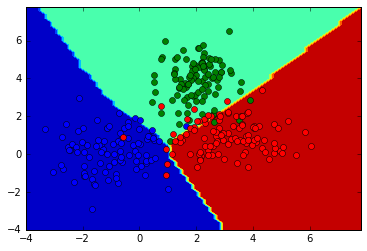

In [12]:
out = fnn.activateOnDataset(griddata)
out = out.argmax(axis=1)  # the highest output activation gives the class
out = out.reshape(X.shape)
figure(2)
clf()
hold(True)
for c in [0,1,2]:
    here, _ = where(tstdata['class']==c)
    plot(tstdata['input'][here,0],tstdata['input'][here,1],'o')
if out.max()!=out.min():
    contourf(X, Y, out)
draw()

As you can see, most of the samples fall into the corresponding area, which means that they are correctly classified. However, a few of them fall in a different area, which is not surprising due to the overlapping of the distributions.
<p>Re-training the network with more epochs will minimize the training error and further adjust the class boundaries, but a 100% correct classification is not feasible.
<table border="0">
<tr>
<td><img src="img/epoch_1.png" size=30%></td>
<td><img src="img/epoch_3.png" size=30%></td>
<td><img src="img/epoch_5.png" size=30%></td>
</tr>
</table>

The performance of the network can be also measured by the <a href="https://en.wikipedia.org/wiki/Confusion_matrix">confusion matrix</a>, where each column represents the instances in a predicted class while each row represents the instances in an actual class (or vice-versa).

In [13]:
from numpy import shape, argmax, zeros, trace, sum, where

def confmat(fnn,ds):
    """Confusion matrix"""

    # Add the inputs that match the bias node
    inputs = ds['input']
    targets = ds['target']
    outputs = []
    for inpt in inputs:
        outputs.append(fnn.activate(inpt))

    nclasses = shape(targets)[1]

    # 1-of-N encoding
    outputs = argmax(outputs,1)
    targets = argmax(targets,1)

    cm = zeros((nclasses,nclasses))
    for i in range(nclasses):
        for j in range(nclasses):
            cm[i,j] = sum(where(outputs==i,1,0)*where(targets==j,1,0))

    print "Confusion matrix is:"
    print cm
    print "Percentage Correct: ",trace(cm)/sum(cm)*100

confmat(fnn,tstdata)

Confusion matrix is:
[[  89.    0.    4.]
 [   2.  101.   14.]
 [   0.    3.   87.]]
Percentage Correct:  92.3333333333


## Exercise

Write a script with all these steps:
<ul>
<li>create a network
<li>create a dataset for the presented classification problem
<li>train the network until the error no longer decreases
<li>display the contour map and the confusion matrix of the network after training
</ul>